In [1]:
#autor: PATRYK KLYTTA
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split

# Konfiguracja TensorFlow do korzystania z GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

base_path = "chest_xray"
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")
test_dir = os.path.join(base_path, "test")

img_size = (224, 224)
batch_size = 32

img_Datagen = ImageDataGenerator(
    rescale=1/255,
    shear_range=10,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 2.0],
    width_shift_range=0.2,
    rotation_range=20,
    fill_mode='nearest',
    validation_split=0.2  
)

val_Datagen = ImageDataGenerator(rescale=1/255)

train_generator = img_Datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['NORMAL', 'PNEUMONIA'],
    subset='training'
)

val_generator = img_Datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['NORMAL', 'PNEUMONIA'],
    subset='validation'
)

test_generator = val_Datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['NORMAL', 'PNEUMONIA'],
    shuffle=False
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


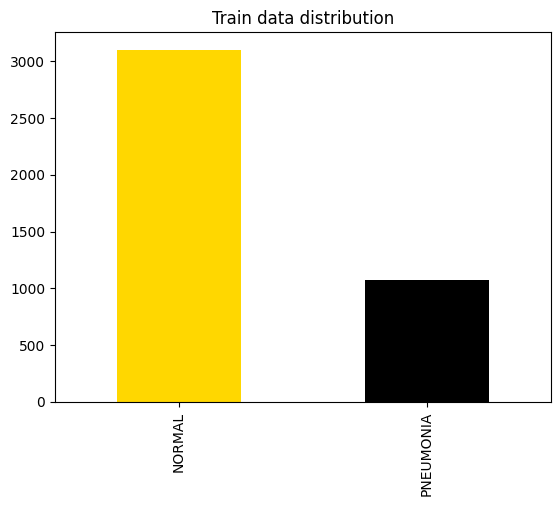

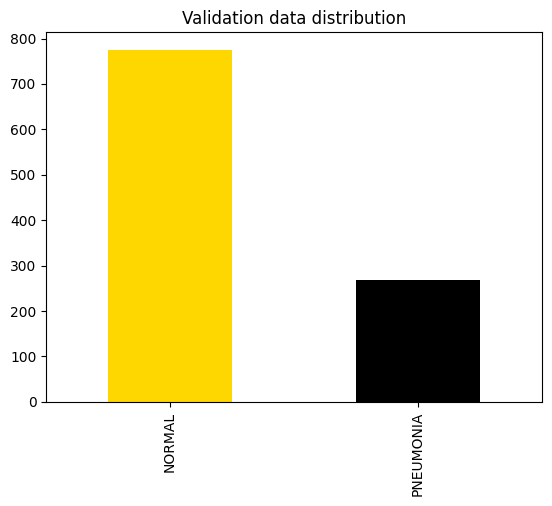

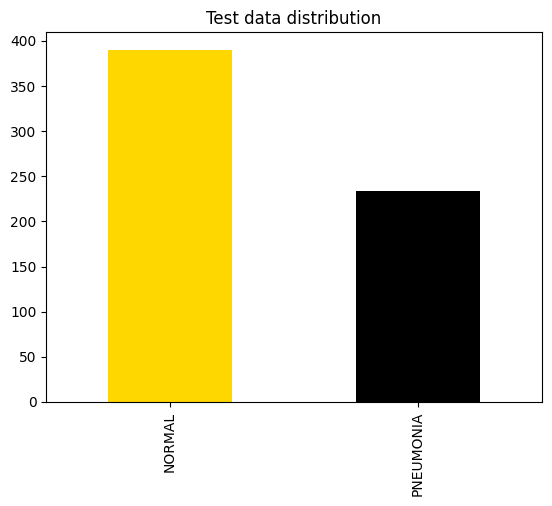

In [2]:
def plot_data_distribution(generator, title):
    labels = generator.classes
    label_counts = pd.Series(labels).value_counts()
    label_counts.index = ['NORMAL', 'PNEUMONIA']
    label_counts.plot(kind='bar', color=['gold', 'black'])
    plt.title(title)
    plt.show()

# Wykres dla zbioru treningowego
plot_data_distribution(train_generator, 'Train data distribution')

# Wykres dla zbioru walidacyjnego
plot_data_distribution(val_generator, 'Validation data distribution')

# Wykres dla zbioru testowego
plot_data_distribution(test_generator, 'Test data distribution')


In [3]:
# Budowa modelu z ResNet50V2
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    layer.trainable = False

x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=resnet_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [4]:
# Trenowanie modelu
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=100,
    batch_size=batch_size
)

Epoch 1/30


c:\Users\pklyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.8484 - loss: 0.3292 - val_accuracy: 0.8523 - val_loss: 0.3360
Epoch 2/30
 31/100 ━━━━━━━━━━━━━━━━━━━━ 54s 784ms/step - accuracy: 0.8798 - loss: 0.2790

c:\Users\pklyt\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 522ms/step - accuracy: 0.8723 - loss: 0.3006 - val_accuracy: 0.8581 - val_loss: 0.3666
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9067 - loss: 0.2476 - val_accuracy: 0.9070 - val_loss: 0.2304
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 490ms/step - accuracy: 0.9081 - loss: 0.2153 - val_accuracy: 0.8859 - val_loss: 0.2709
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9172 - loss: 0.1990 - val_accuracy: 0.8984 - val_loss: 0.2423
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 487ms/step - accuracy: 0.9264 - loss: 0.1798 - val_accuracy: 0.9137 - val_loss: 0.2099
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9114 - loss: 0.2062 - val_accuracy: 0.9223 - val_loss: 0.1928
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 479ms/step - accuracy: 0.9228 - loss: 0.2005 - val_accuracy: 0.9291 - val_loss: 0.1872
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9227 - loss: 0.1876 - val_accurac

In [5]:
# Ewaluacja modelu na zbiorze testowym
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 640ms/step - accuracy: 0.8919 - loss: 0.3403
Test Accuracy: 0.9134615659713745


In [7]:
# Zapis modelu
model.save("resnet_pneumonia_model_PKlytta.keras")


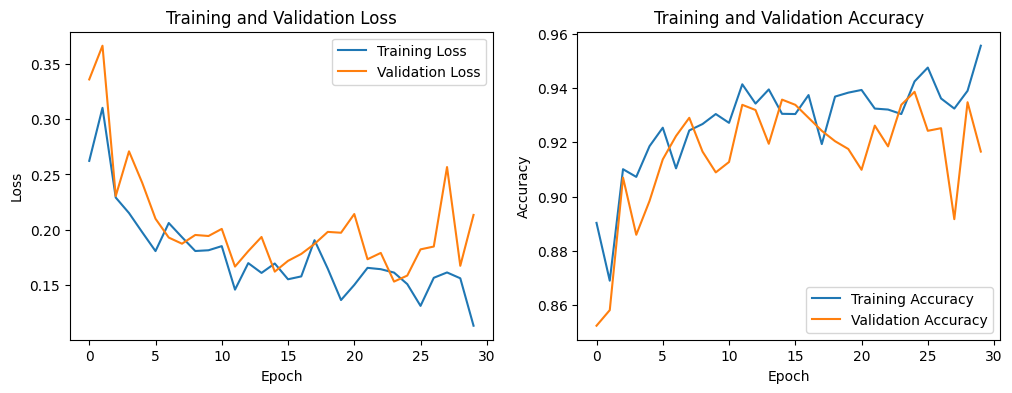

In [8]:
# Wizualizacja wyników trenowania
plt.figure(figsize=(12, 4))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 678ms/step


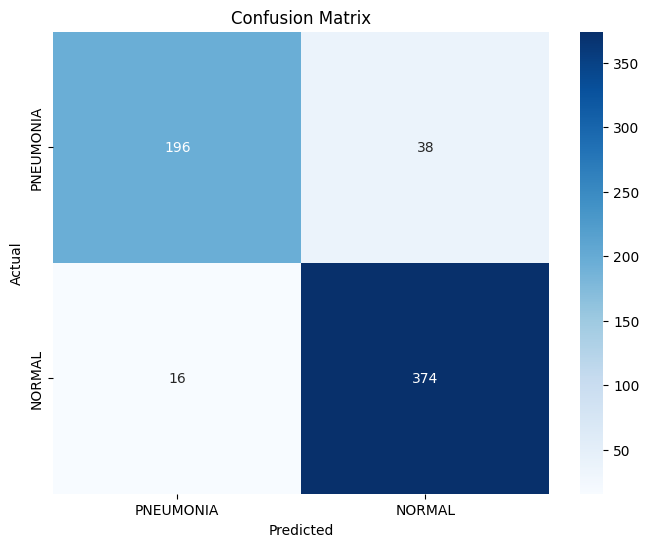

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predykcje na zbiorze testowym
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  # Przekształcenie predykcji na klasy binarne
y_true = test_generator.classes

# Generowanie macierzy pomyłek
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Obliczanie F-score dla zbioru testowego
print("Classification Report for Test Set")
print(classification_report(y_true, y_pred_classes, target_names=['NORMAL', 'PNEUMONIA']))

# Obliczanie F-score dla zbioru treningowego
y_train_pred = model.predict(train_generator)
y_train_pred_classes = (y_train_pred > 0.5).astype("int32")
y_train_true = train_generator.classes

print("Classification Report for Training Set")
print(classification_report(y_train_true, y_train_pred_classes, target_names=['NORMAL', 'PNEUMONIA']))

# Obliczanie F-score dla zbioru walidacyjnego
y_val_pred = model.predict(val_generator)
y_val_pred_classes = (y_val_pred > 0.5).astype("int32")
y_val_true = val_generator.classes

print("Classification Report for Validation Set")
print(classification_report(y_val_true, y_val_pred_classes, target_names=['NORMAL', 'PNEUMONIA']))


Classification Report for Test Set
              precision    recall  f1-score   support

      NORMAL       0.92      0.84      0.88       234
   PNEUMONIA       0.91      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624

131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 814ms/step
Classification Report for Training Set
              precision    recall  f1-score   support

      NORMAL       0.25      0.21      0.23      1073
   PNEUMONIA       0.74      0.78      0.76      3100

    accuracy                           0.64      4173
   macro avg       0.50      0.50      0.50      4173
weighted avg       0.62      0.64      0.63      4173

33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 803ms/step
Classification Report for Validation Set
              precision    recall  f1-score   support

      NORMAL       0.24      0.21      0.22       268
   PNEUMONIA       0.74      0.78  

In [12]:
#MODEL NR 2 - inceptionV3:

from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import InceptionV3

# Budowa modelu z InceptionV3
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in inception_model.layers:
    layer.trainable = False

x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) 
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inception_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#wczesne zatrzymywanie
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 48s 1us/step


In [13]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=100,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 858ms/step - accuracy: 0.7377 - loss: 0.6284 - val_accuracy: 0.8380 - val_loss: 0.3385
Epoch 2/30
 31/100 ━━━━━━━━━━━━━━━━━━━━ 36s 531ms/step - accuracy: 0.8303 - loss: 0.3546

c:\Users\pklyt\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8389 - loss: 0.3466 - val_accuracy: 0.8639 - val_loss: 0.3257
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 834ms/step - accuracy: 0.8460 - loss: 0.3492 - val_accuracy: 0.8677 - val_loss: 0.2932
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 358ms/step - accuracy: 0.8786 - loss: 0.3004 - val_accuracy: 0.8591 - val_loss: 0.3039
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 810ms/step - accuracy: 0.8623 - loss: 0.3272 - val_accuracy: 0.8792 - val_loss: 0.2713
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 365ms/step - accuracy: 0.8759 - loss: 0.2905 - val_accuracy: 0.7929 - val_loss: 0.4500
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 788ms/step - accuracy: 0.8728 - loss: 0.3139 - val_accuracy: 0.8792 - val_loss: 0.2725
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 352ms/step - accuracy: 0.8477 - loss: 0.3398 - val_accuracy: 0.8686 - val_loss: 0.3050
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 794ms/step - accuracy: 0.8666 - loss: 0.2943 - val

In [15]:
# Ewaluacja modelu na zbiorze testowym
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step - accuracy: 0.7031 - loss: 0.6269
Test Accuracy: 0.807692289352417


In [17]:
# Zapis modelu
model.save("inceptionV3_pneumonia_model_PKlytta.keras")


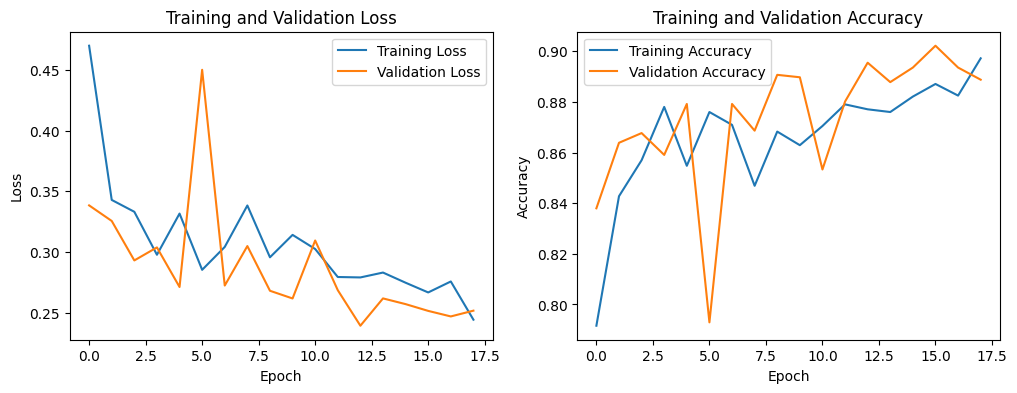

In [18]:
# Wizualizacja wyników trenowania
plt.figure(figsize=(12, 4))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step


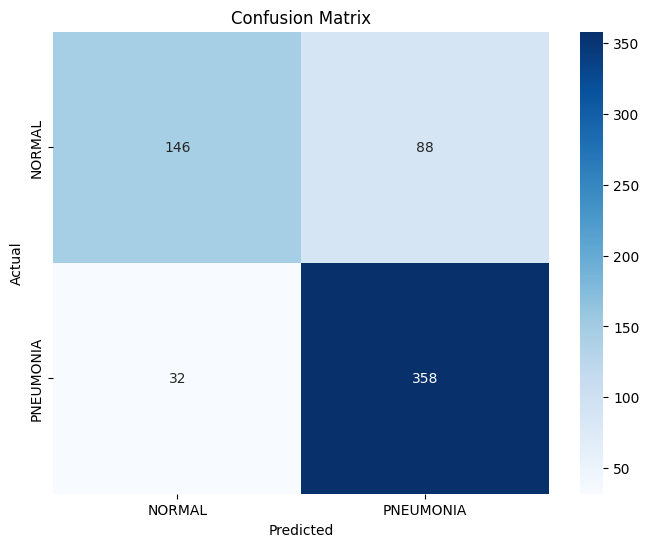

In [19]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true = test_generator.classes  

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Obliczanie F-score dla zbioru testowego
print("Classification Report for Test Set")
print(classification_report(y_true, y_pred_classes, target_names=['NORMAL', 'PNEUMONIA']))

# Obliczanie F-score dla zbioru treningowego
y_train_pred = model.predict(train_generator)
y_train_pred_classes = (y_train_pred > 0.5).astype("int32")
y_train_true = train_generator.classes

print("Classification Report for Training Set")
print(classification_report(y_train_true, y_train_pred_classes, target_names=['NORMAL', 'PNEUMONIA']))

# Obliczanie F-score dla zbioru walidacyjnego
y_val_pred = model.predict(val_generator)
y_val_pred_classes = (y_val_pred > 0.5).astype("int32")
y_val_true = val_generator.classes

print("Classification Report for Validation Set")
print(classification_report(y_val_true, y_val_pred_classes, target_names=['NORMAL', 'PNEUMONIA']))

Classification Report for Test Set
              precision    recall  f1-score   support

      NORMAL       0.82      0.62      0.71       234
   PNEUMONIA       0.80      0.92      0.86       390

    accuracy                           0.81       624
   macro avg       0.81      0.77      0.78       624
weighted avg       0.81      0.81      0.80       624

131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 604ms/step
Classification Report for Training Set
              precision    recall  f1-score   support

      NORMAL       0.25      0.21      0.23      1073
   PNEUMONIA       0.74      0.78      0.76      3100

    accuracy                           0.64      4173
   macro avg       0.50      0.50      0.50      4173
weighted avg       0.62      0.64      0.63      4173

33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 595ms/step
Classification Report for Validation Set
              precision    recall  f1-score   support

      NORMAL       0.26      0.23      0.25       268
   PNEUMONIA       0.74      0.77   